# Image Denoising
Using a convolutional autoencoder to remove noise from an image

In [62]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import PIL
import os
plt.style.use('ggplot')

In [63]:
# def salt_and_pepper(img, p):
#     '''
#     Adds "salt and pepper" noise to an image.
#     p (between 0 and 1) percent of the pixels are changed to be either
#     black or white with an equal liklihood of either
#     '''

#     if p < 0 or p > 1:
#         raise ValueError("p should be between 0 and 1")

#     assert(type(img) == torch.Tensor)
#     img_copy = img.clone().numpy()

#     n = int(p * img_copy.size)
#     indices_to_change = np.random.choice(img_copy.size, n, replace=False)
#     random_values = np.random.randint(0, 2, n)
#     img_copy.flat[indices_to_change] = random_values

#     return torch.from_numpy(img_copy).reshape(1, img.shape[0], img.shape[1])

def salt_and_pepper(img, p):
    out = (img + torch.normal(0, p, img.shape)).clip(0,1)
    return out


In [64]:
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise=0.05):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.noise = noise

        # images and labels are the same, images are just noisy
        self.images = [] # paths to the images

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # loads the images from path only when requested
        image_path = self.images[idx]
        label = None

        with open(image_path, 'rb') as f:
            image = PIL.Image.open(f)
            if self.transform:
                image = self.transform(image)
                label = image.clone() # clear image is the label
                # image = salt_and_pepper(image.squeeze(),self.noise) # add noise
                image = salt_and_pepper(image,self.noise) # add noise

        return image, label


In [65]:
# Resize, grayscale, convert to tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])
batch_size = 50

# Create training and testing dataloaders
train_loader = DataLoader(
    DenoisingDataset(root_dir="./datasets/sports/train/", transform=transform, noise=0.1),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    DenoisingDataset(root_dir="./datasets/sports/test/", transform=transform, noise=0.1),
    batch_size=batch_size,
    shuffle=True
)

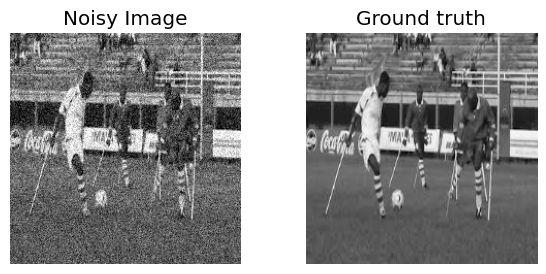

In [66]:
# Show an example of an image and its label
data_iter = iter(train_loader)
images, labels = next(data_iter)

# get a random noisy image and label (ground truth) from the batch
idx = np.random.randint(0, batch_size)  # Choose a random index within the batch
image = images[idx]
label = labels[idx]
image = image.squeeze().numpy()
label = label.squeeze().numpy()

# show image and ground truth
fig, ax = plt.subplots(1,2, figsize=(7,3));
ax[0].imshow(image, cmap="gray");
ax[0].set_title("Noisy Image")
ax[0].axis('off');
ax[1].imshow(label, cmap="gray");
ax[1].set_title("Ground truth")
ax[1].axis('off');


In [67]:
# Create the convolutional autoencoder neural network
class ConvAutoEncoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [68]:
# Instatiate the model, loss function, and optimizer.
# Adam works but I couldn't get SGD to converge
model = ConvAutoEncoder().cuda()
criterion = torch.nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 270/270 [00:32<00:00,  8.41it/s]


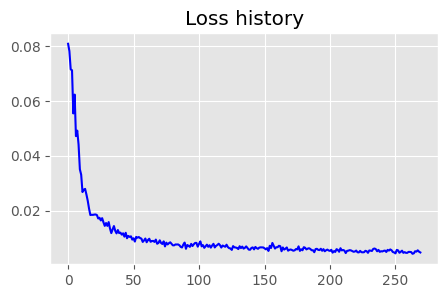

In [69]:
loss_hist = []
for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    model.train()
    optimizer.zero_grad()

    # Do a forward pass to get a prediction from the model
    pred = model(data.cuda())

    # Compute the loss
    loss = criterion(pred, target.cuda())
    loss_hist.append(loss.item())

    # Compute gradients and take a gradient step
    loss.backward()
    optimizer.step()


# plot the loss history
fig, ax = plt.subplots(figsize=(5,3));
ax.plot(loss_hist, color="blue");
ax.set(title="Loss history");

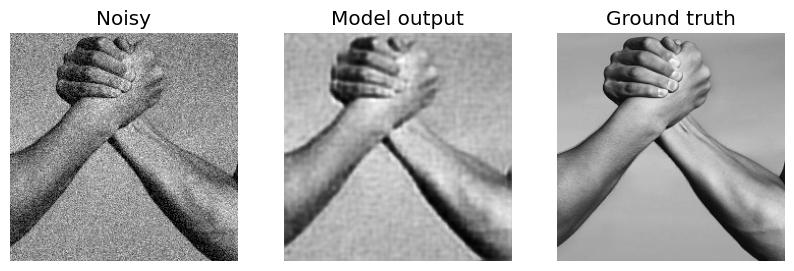

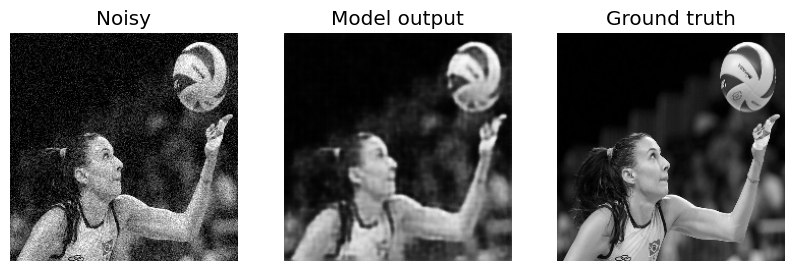

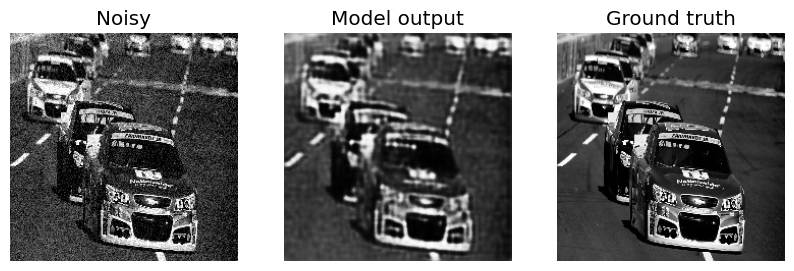

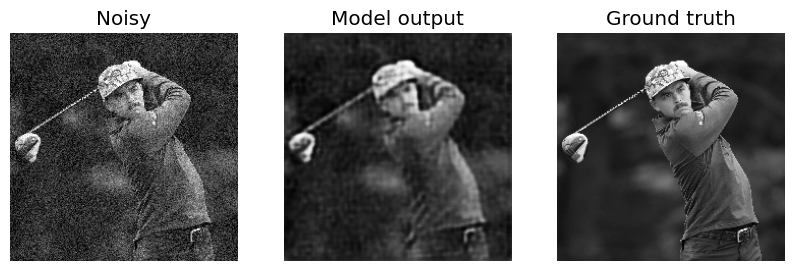

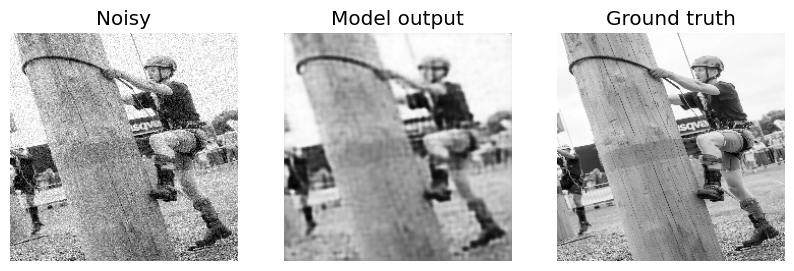

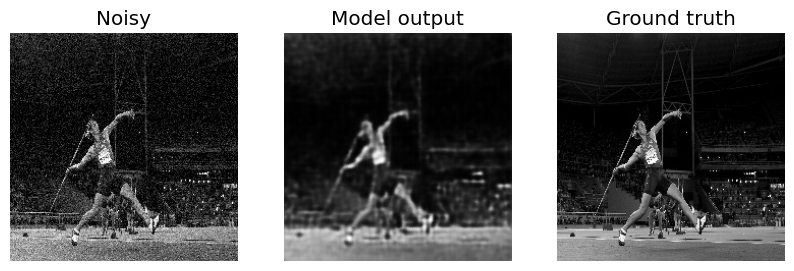

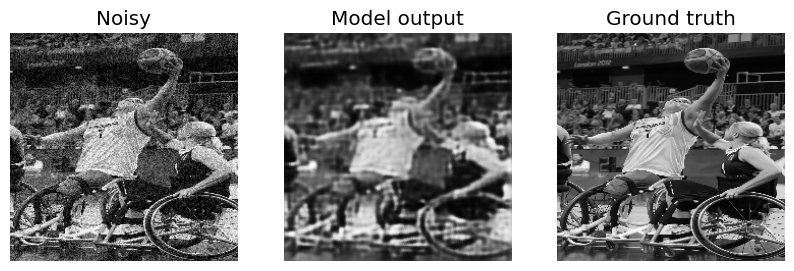

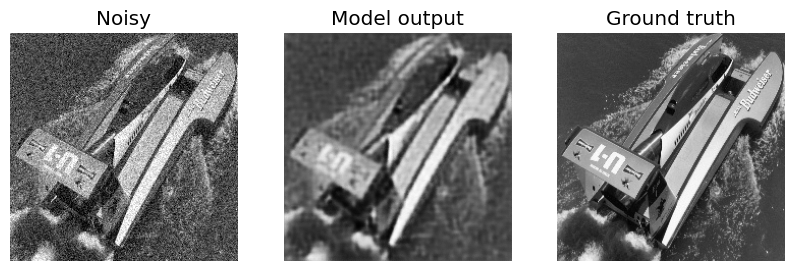

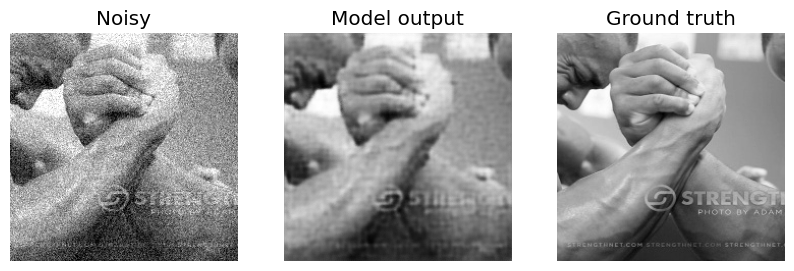

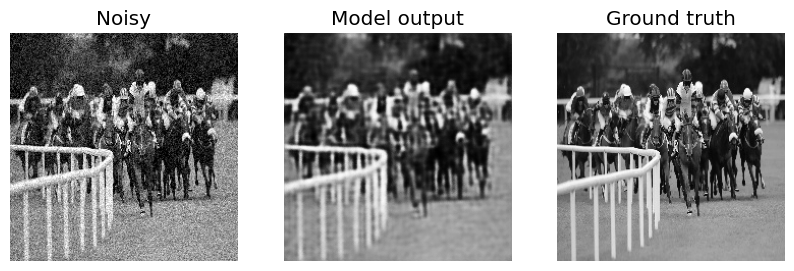

In [70]:
with torch.no_grad():
    model.cpu()

    # Get a batch of test images
    test_iter = iter(test_loader)
    images, labels = next(test_iter)

    # run the images through the trained model
    out = model(images)

    # plot the first 10 along with labels
    for i in range(10):
        fig, ax = plt.subplots(1,3, figsize=(10,5))

        ax[0].axis('off')
        ax[0].set_title("Noisy")
        ax[0].imshow(images[i].squeeze(), cmap="gray")

        ax[1].axis('off')
        ax[1].set_title("Model output")
        ax[1].imshow(out[i].squeeze(), cmap="gray")

        ax[2].axis('off')
        ax[2].set_title("Ground truth")
        ax[2].imshow(labels[i].squeeze(), cmap="gray")

